<a href="https://colab.research.google.com/github/jimmiemunyi/deeplearning-experiments/blob/main/notebooks/Learning_from_Sound_with_PyTorch_Respiratory_Sounds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install -Uqq fastai==2.5.2 torchaudio==0.9.0

     |████████████████████████████████| 186 kB 11.1 MB/s 
     |████████████████████████████████| 1.9 MB 44.8 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 


In [ ]:
import librosa
import librosa.display
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

import torchaudio
import torchaudio.transforms as T

from torch.utils.data import DataLoader, Dataset, random_split

from IPython.display import Audio

from fastai.vision.all import *
from fastcore.all import *

In [ ]:
torch.random.manual_seed(4);

# Utility Functions

In [ ]:
#hide

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

# Cell
from importlib_metadata import version
def get_version(lib):
    "Returns version of `lib`, can be either a `str` representation or the module itself"
    if isinstance(lib, str): return version(lib)
    else:
        try:
            return lib.__version__
        except:
            raise TypeError('`lib` should either be the string name of the module or the module itself')

# Cell
from IPython.display import Markdown
import warnings
def state_versions(*libs):
    "State all the versions currently installed from `libs` in Markdown"
    cell = f"""
---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.
"""
    if isinstance(libs[0], list):
        warnings.warn('''Passing in a list of libraries will be deprecated, you should pass them directly such as:
        `state_versions(fastai, fastcore)`
        or:
        `state_versions('fastai', 'fastcore')`
        ''', category=DeprecationWarning)
        libs = libs[0]
    cell += 'Below are the versions of '
    for i, lib in enumerate(libs):
        nm = lib if isinstance(lib, str) else lib.__name__
        if len(libs) == 1: cell += f'`{nm}`'
        elif i < len(libs)-1:
            cell += ''.join(f'`{nm}`')
            if len(libs) > 2: cell += ', '
            else: cell += ' '
        elif len(libs) > 1: cell += ''.join(f'and `{nm}`')
    cell += ' currently running at the time of writing this:\n'
    for lib in libs:
        nm = lib if isinstance(lib, str) else lib.__name__
        cell += f'* `{nm}` : {get_version(lib)} \n'
    cell += '---'
    return Markdown(cell)

import IPython
# display various wave forms of a file
def display_wav(patient_id, target):
    patient_sounds = list(data_path.glob(f'audio_and_txt_files/{patient_id}*.wav'))
    test_wav = librosa.core.load(patient_sounds[0], sr=44100)[0]

    fig, ax = plt.subplots(5, 1, figsize=(20,18))
    ax[0].plot(test_wav)
    ax[0].set_title(f"Full {target} waveform")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=512, 
                                         hop_length=256, win_length=512, 
                                         window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[1].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[1].set_title(f"Slice of {target} mel spectrogram 512 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=1024, 
                                         hop_length=256, win_length=1024, 
                                         window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[2].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[2].set_title(f"Slice of {target} mel spectrogram 1024 fft")

    mel = librosa.feature.melspectrogram(test_wav, sr=44100, n_fft=2048, 
                                         hop_length=256, win_length=1024, 
                                         window='hann', n_mels=100)
    mel[mel < 1e-12] = 1e-12
    ax[3].imshow(np.log(mel)[:,:1000], origin='lower')
    ax[3].set_title(f"Slice of {target} mel spectrogram 2048 fft")
    
    chroma = librosa.feature.chroma_stft(test_wav, sr=44100, n_fft=2048, 
                                         hop_length=256, win_length=1024, 
                                         window='hann')
    ax[4].imshow(chroma[:,:1000], origin='lower')
    ax[4].set_title(f"Slice of {target} chromagram 2048 fft")

In [ ]:
state_versions('fastai', 'fastcore', 'torchaudio')


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.
Below are the versions of `fastai`, `fastcore`, and `torchaudio` currently running at the time of writing this:
* `fastai` : 2.5.2 
* `fastcore` : 1.3.26 
* `torchaudio` : 0.9.0 
---

## Getting the Dataset

Upload `kaggle.json` before running the following cells

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir data

[link](https://www.kaggle.com/vbookshelf/respiratory-sound-database)

In [ ]:
!kaggle datasets download -d vbookshelf/respiratory-sound-database

 97% 3.59G/3.69G [01:18<00:01, 72.1MB/s]

In [ ]:
#collapse_output
! unzip respiratory-sound-database.zip -d data && rm -rf respiratory-sound-database.zip

Archive:  respiratory-sound-database.zip
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.txt  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Al_sc_Meditron.wav  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.txt  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/101_1b1_Pr_sc_Meditron.wav  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.txt  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/102_1b1_Ar_sc_Meditron.wav  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2SE.txt  
  inflating: data/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/103_2b2_Ar_mc_LittC2

# Mel Spectograms

In [ ]:
data_path = Path('data/respiratory_sound_database/Respiratory_Sound_Database')

In [ ]:
#hide
Path.BASE_PATH = data_path

In [ ]:
data_path.ls()

(#4) [Path('patient_diagnosis.csv'),Path('audio_and_txt_files'),Path('filename_format.txt'),Path('filename_differences.txt')]

In [ ]:
(data_path/'audio_and_txt_files').ls(file_exts='.wav')[0]

Path('audio_and_txt_files/188_1b1_Al_sc_Meditron.wav')

In [ ]:
AUDIO_FILE = (data_path/'audio_and_txt_files').ls(file_exts='.wav')[0]
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

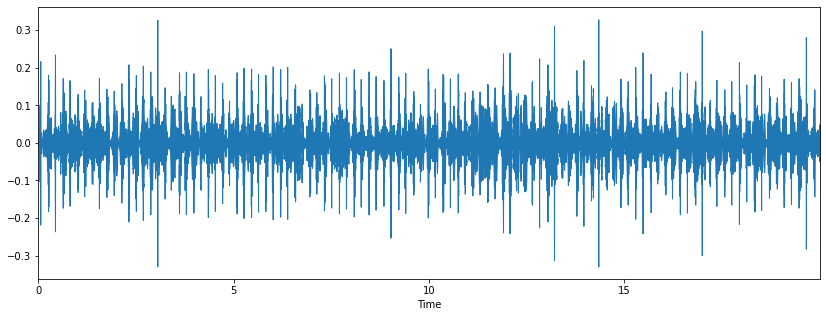

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sample_rate);

In [ ]:
Audio(filename=AUDIO_FILE)

In [ ]:
data_path.ls()

(#4) [Path('patient_diagnosis.csv'),Path('audio_and_txt_files'),Path('filename_format.txt'),Path('filename_differences.txt')]

/usr/local/lib/python3.7/dist-packages/librosa/display.py:955: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


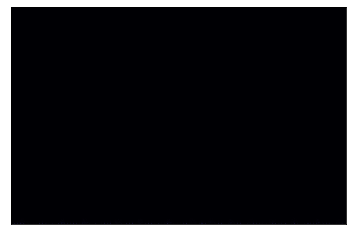

In [ ]:
sgram = librosa.stft(samples)
librosa.display.specshow(sgram);

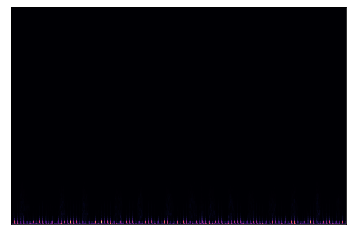

In [ ]:
# use the mel-scale instead of raw frequency
sgram_mag,_ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
librosa.display.specshow(mel_scale_sgram);

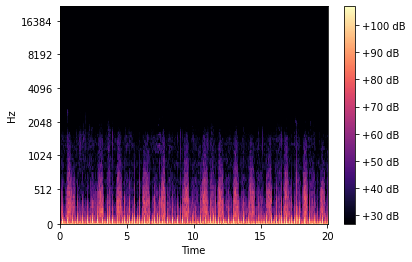

In [ ]:
# use the decibel scale to get the final Mel Spectogram
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');


In [ ]:
#Spectrogram is a 2D numpy array
print(type(mel_sgram), mel_sgram.shape)

<class 'numpy.ndarray'> (128, 1723)


# Torchaudio

In [ ]:
waveform, sample_rate = torchaudio.load(AUDIO_FILE)

print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 44100
Shape: (1, 882000)
Dtype: torch.float32
 - Max:      0.329
 - Min:     -0.198
 - Mean:    -0.000
 - Std Dev:  0.050

tensor([[ 0.0039,  0.0037,  0.0037,  ..., -0.0126, -0.0128, -0.0131]])



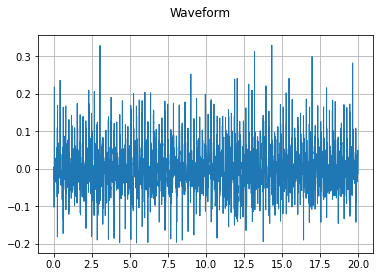

In [ ]:
plot_waveform(waveform, sample_rate);
plot_specgram(waveform, sample_rate);

In [ ]:
play_audio(waveform, sample_rate)

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(
    melspec[0], title="MelSpectrogram", ylabel='mel freq')

MFCC

In [ ]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc = mfcc_transform(waveform)

plot_spectrogram(mfcc[0]);

SpecAugment

TimeMasking

In [ ]:
plot_spectrogram(melspec[0], title="Original")

time_masking = T.TimeMasking(time_mask_param=80)
spec = time_masking(melspec)

plot_spectrogram(spec[0], title="Masked along time axis")

FrequencyMasking

In [ ]:
plot_spectrogram(melspec[0], title="Original")

freq_masking = T.FrequencyMasking(freq_mask_param=80)
spec = freq_masking(melspec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

Both

In [ ]:
spec_augment = nn.Sequential(
    time_masking,
    freq_masking
)

spec = spec_augment(melspec)

plot_spectrogram(spec[0], title="SpecAugment")

# Tabular Data Stuff

Complete it Later

In [ ]:
df = pd.read_csv(data_path/'patient_diagnosis.csv', 
                 names=['Patient number', 'Diagnosis'])

df.head()

Patient number Diagnosis
0             101      URTI
1             102   Healthy
2             103    Asthma
3             104      COPD
4             105      URTI

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


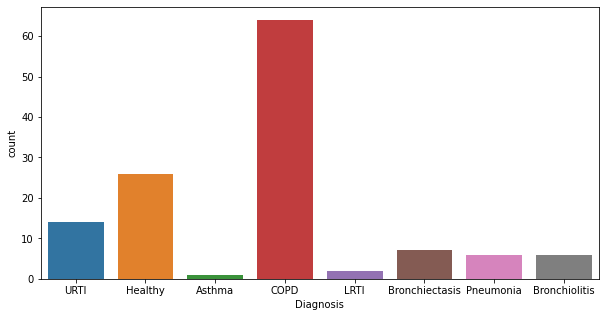

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['Diagnosis']);

In [ ]:
df_no_diagnosis = pd.read_csv('data/demographic_info.txt', delimiter=' ',
                              names=['Patient number', 'Age', 'Sex' , 'Adult BMI (kg/m2)', 'Child Weight (kg)' , 'Child Height (cm)'],
                             )
df_no_diagnosis.head(5)

Patient number    Age  ... Child Weight (kg)  Child Height (cm)
0             101   3.00  ...              19.0               99.0
1             102   0.75  ...               9.8               73.0
2             103  70.00  ...               NaN                NaN
3             104  70.00  ...               NaN                NaN
4             105   7.00  ...              32.0              135.0

[5 rows x 6 columns]

In [ ]:
df = df_no_diagnosis.join(df.set_index('Patient number'), on='Patient number',
                           how='left')

df.head()

Patient number    Age Sex  ...  Child Weight (kg)  Child Height (cm)  Diagnosis
0             101   3.00   F  ...               19.0               99.0       URTI
1             102   0.75   F  ...                9.8               73.0    Healthy
2             103  70.00   F  ...                NaN                NaN     Asthma
3             104  70.00   F  ...                NaN                NaN       COPD
4             105   7.00   F  ...               32.0              135.0       URTI

[5 rows x 7 columns]

Most Important Column are not missing anything: Patient number and Diagnosis

Later could use the other data as tabular input

In [ ]:
df.isna().sum()

Patient number        0
Age                   1
Sex                   1
Adult BMI (kg/m2)    51
Child Weight (kg)    82
Child Height (cm)    84
Diagnosis             0
dtype: int64

In [ ]:
df['Diagnosis'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Bronchiolitis      6
Pneumonia          6
LRTI               2
Asthma             1
Name: Diagnosis, dtype: int64

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


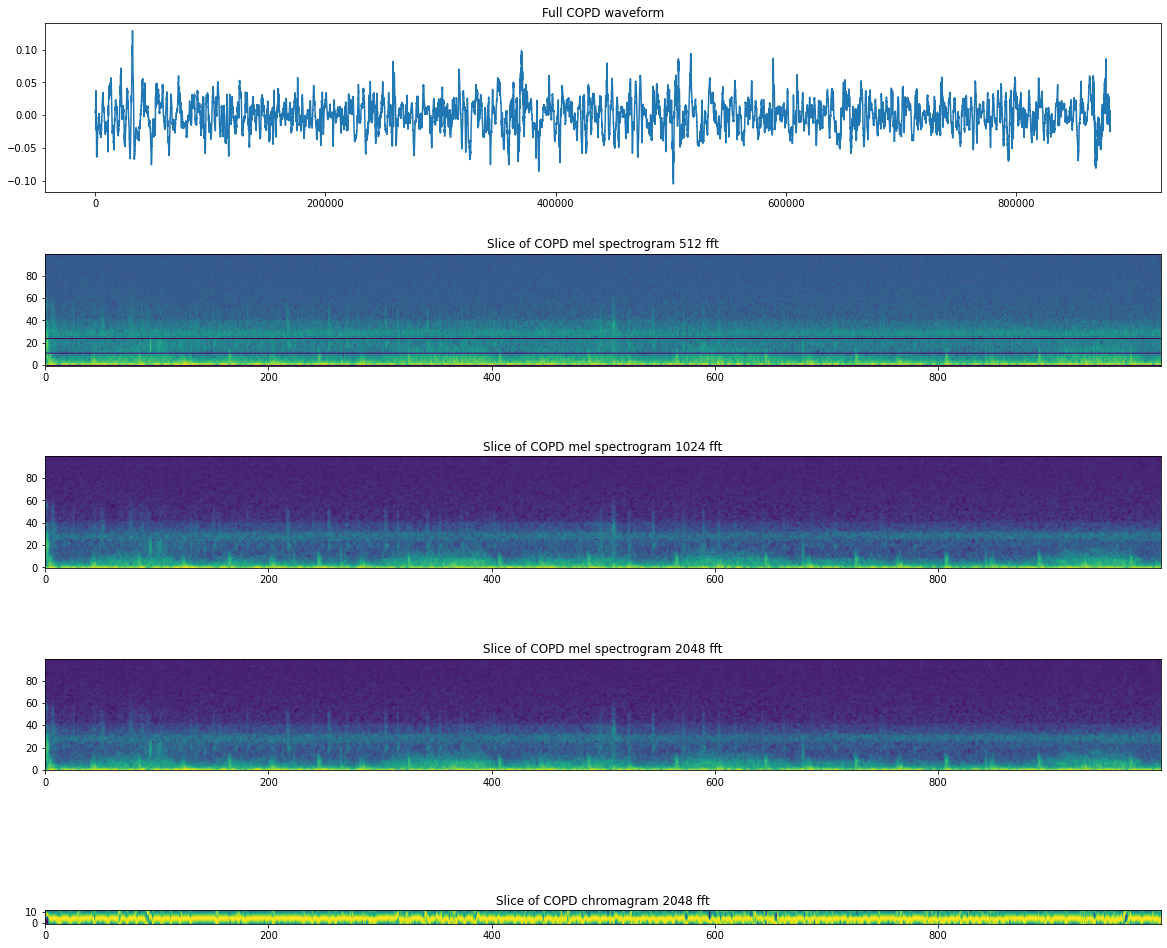

In [ ]:
display_wav(102, 'COPD');

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


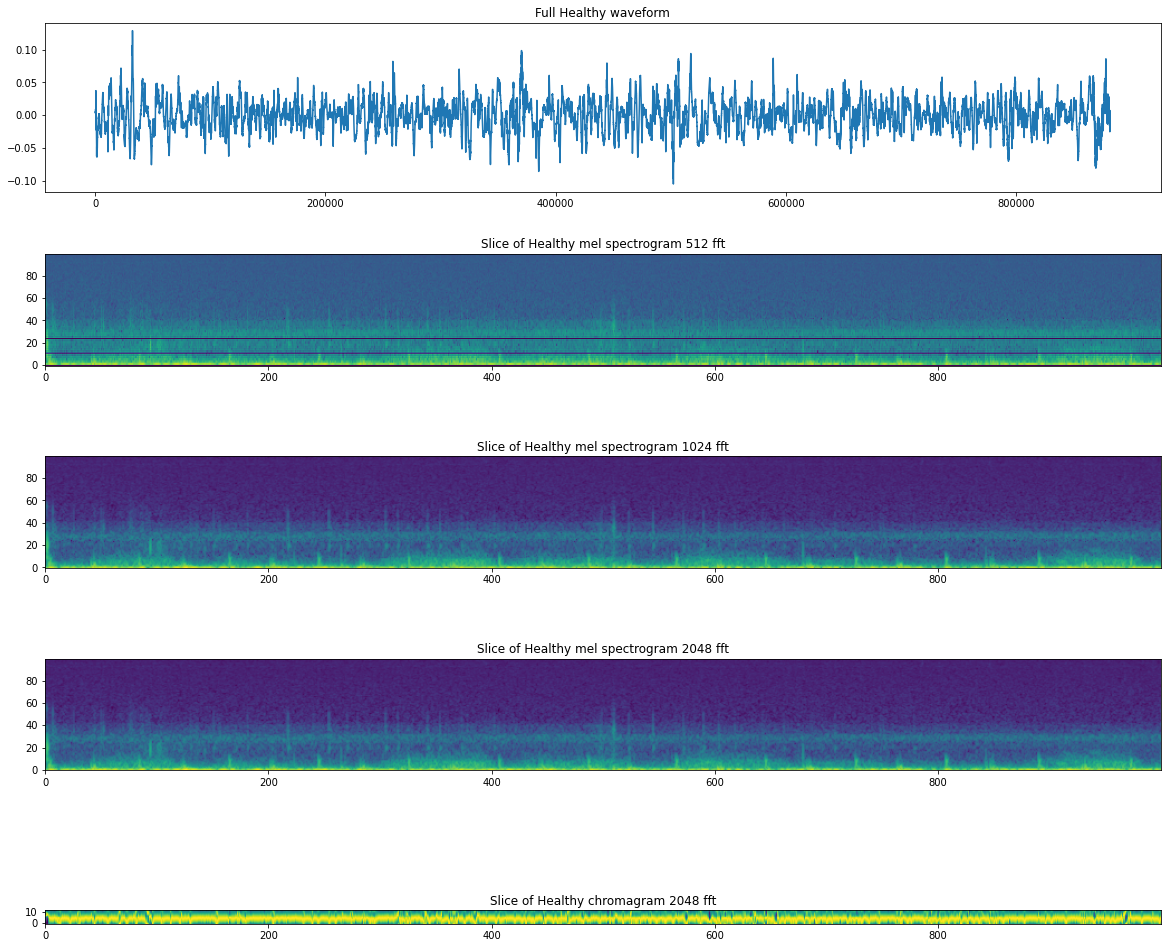

In [ ]:
display_wav(102, 'Healthy');

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


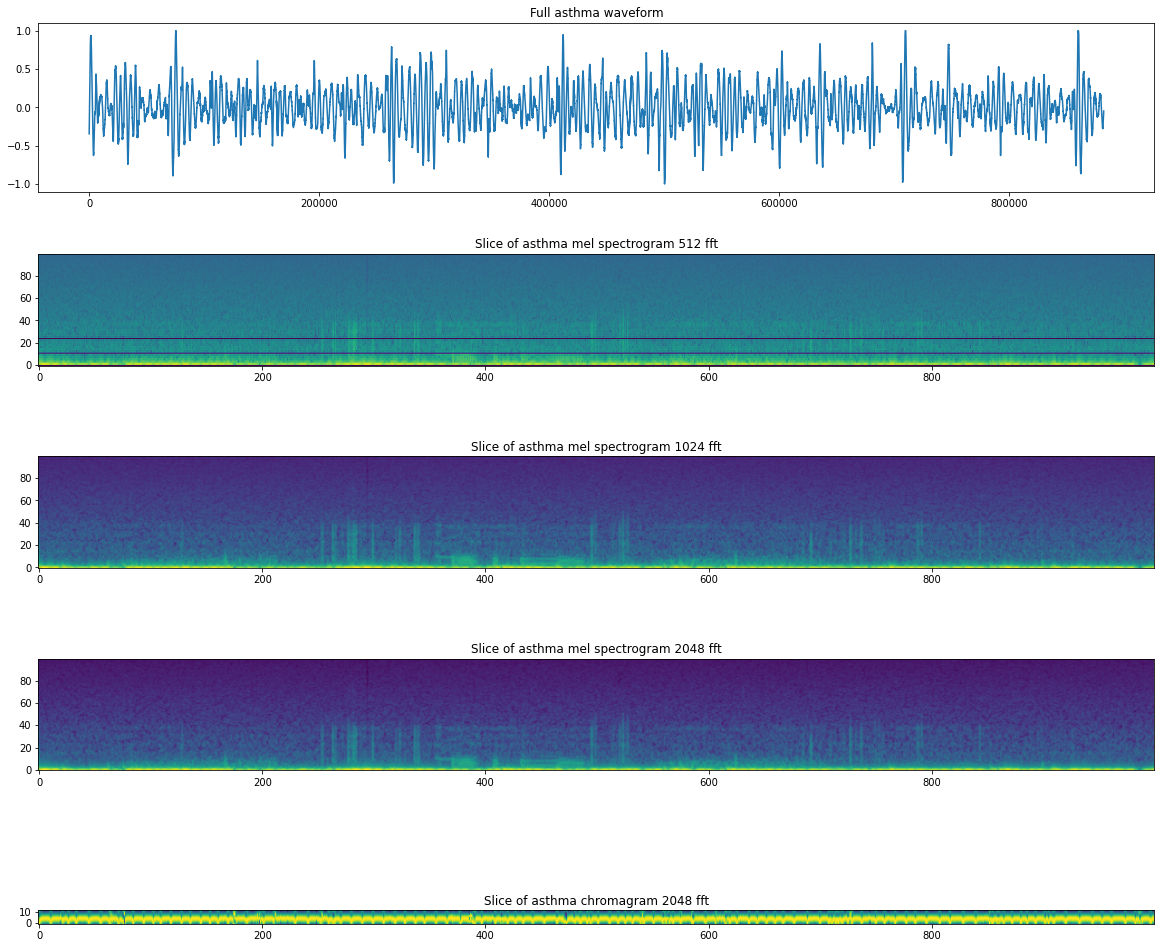

In [ ]:
display_wav(103, "asthma")

In [ ]:
(data_path/'audio_and_txt_files').ls()[0]

Path('audio_and_txt_files/188_1b1_Al_sc_Meditron.wav')

patient_number recording_index chest_location acquisition_mode recording_equipment

In [ ]:
(data_path/'audio_and_txt_files/130_1p3_Pl_mc_AKGC417L.txt').open().read()

'1.066\t4.899\t0\t1\n4.899\t8.256\t0\t1\n8.256\t11.673\t0\t1\n11.673\t15.077\t0\t1\n15.077\t18.375\t0\t1\n18.375\t19.946\t0\t0\n'

In [ ]:
example_file = pd.read_csv(data_path/'audio_and_txt_files/130_1p3_Pl_mc_AKGC417L.txt', 
                           delimiter='\t', 
                           names=['Beginning', 'End', 'Crackle' , 'Whiz'],
                             )
example_file

Beginning     End  Crackle  Whiz
0      1.066   4.899        0     1
1      4.899   8.256        0     1
2      8.256  11.673        0     1
3     11.673  15.077        0     1
4     15.077  18.375        0     1
5     18.375  19.946        0     0

dont forget unique mics and unique locations

im thinking create a better dataframe with all these then ML on it

deal with all these later

# Deep Learning of on the Mel Spectograms

How to get y

In [ ]:
path = (data_path/'audio_and_txt_files').ls()[0]

In [ ]:
df.head()

Patient number    Age Sex  ...  Child Weight (kg)  Child Height (cm)  Diagnosis
0             101   3.00   F  ...               19.0               99.0       URTI
1             102   0.75   F  ...                9.8               73.0    Healthy
2             103  70.00   F  ...                NaN                NaN     Asthma
3             104  70.00   F  ...                NaN                NaN       COPD
4             105   7.00   F  ...               32.0              135.0       URTI

[5 rows x 7 columns]

In [ ]:
df[df['Patient number'] == int(path.stem[:3])]['Diagnosis'].item()

'URTI'

put that in a function

In [ ]:
def get_y(path):
  return df[df['Patient number'] == int(path.stem[:3])]['Diagnosis'].item()

In [ ]:
get_y((data_path/'audio_and_txt_files').ls()[100])

'COPD'

How to get X

In [ ]:
n_fft=1024
hop_length=256
target_rate=44100
num_samples=int(target_rate)

In [ ]:
# def get_items(path): 
#     fns = L([fn for fn in get_files(path, extensions='.wav'))
#     return fns
files = (data_path/'audio_and_txt_files/').ls(file_exts='.wav')
files

(#920) [Path('audio_and_txt_files/188_1b1_Al_sc_Meditron.wav'),Path('audio_and_txt_files/170_1b3_Al_mc_AKGC417L.wav'),Path('audio_and_txt_files/210_1b1_Al_sc_Meditron.wav'),Path('audio_and_txt_files/130_3p4_Al_mc_AKGC417L.wav'),Path('audio_and_txt_files/223_1b1_Ar_sc_Meditron.wav'),Path('audio_and_txt_files/107_2b3_Lr_mc_AKGC417L.wav'),Path('audio_and_txt_files/225_1b1_Pl_sc_Meditron.wav'),Path('audio_and_txt_files/219_2b3_Tc_mc_LittC2SE.wav'),Path('audio_and_txt_files/156_8b3_Pl_mc_AKGC417L.wav'),Path('audio_and_txt_files/174_1p3_Tc_mc_AKGC417L.wav')...]

In [ ]:
get_y(files[121])

'COPD'

In [ ]:
n_fft = 1024
win_length = None
hop_length = 256
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)


def get_x(file):
  waveform, sample_rate = torchaudio.load(file)
  return mel_spectrogram(waveform)


/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
files[0]

Path('audio_and_txt_files/188_1b1_Al_sc_Meditron.wav')

In [ ]:
x, rate = torchaudio.load(files[0])
x.shape, rate

(torch.Size([1, 882000]), 44100)

In [ ]:
print_stats(x)

Shape: (1, 882000)
Dtype: torch.float32
 - Max:      0.329
 - Min:     -0.198
 - Mean:    -0.000
 - Std Dev:  0.050

tensor([[ 0.0039,  0.0037,  0.0037,  ..., -0.0126, -0.0128, -0.0131]])



# Audio Classification with PyTorch

In [ ]:
df.head()

Patient number    Age Sex  ...  Child Weight (kg)  Child Height (cm)  Diagnosis
0             101   3.00   F  ...               19.0               99.0       URTI
1             102   0.75   F  ...                9.8               73.0    Healthy
2             103  70.00   F  ...                NaN                NaN     Asthma
3             104  70.00   F  ...                NaN                NaN       COPD
4             105   7.00   F  ...               32.0              135.0       URTI

[5 rows x 7 columns]

Audio Utility for processing our files

In [ ]:
# Audio utility function
class AudioUtil():
  """
  This is a utility function for the following functions:
  -------------------------------------------------------
  * loading audio files
  * rechanneling the audio files
  * resampling the audio files
  * padding or truncating the audio files
  * Time Shift Data Augmentation
  * Converting waveform into Mel Spectrogram
  * Data Augmentation on Spectrogram (SpecAugment)

  """

  # load audio and return signal as tensor and the sample rate
  @staticmethod
  def load(path):
    waveform, sample_rate = torchaudio.load(path)
    return (waveform, sample_rate)
  
  # conversion of channels (Mono to Stereo and vice versa)
  @staticmethod
  def rechannel(audio, new_channel):
    waveform, sample_rate = audio

    if (waveform.shape[0] == new_channel):
      # no rechanneling needed
      return audio
    
    if (new_channel==1):
      # converting stereo to mono
      # by selecting the first channel
      new_waveform = waveform[:1,:]
    elif (new_channel==2):
      # converting mono to stereo
      # by duplicating the first channel
      new_waveform = torch.cat([waveform, waveform])
    
    return (new_waveform, sample_rate)
  
  # resampling
  @staticmethod
  def resample(audio, new_sr):
    waveform, sr = audio

    if (sr==new_sr):
      # no resampling needed
      return audio
    
    num_channels = waveform.shape[0]

    # resample first channel
    new_audio = torchaudio.transforms.Resample(sr, new_sr)(waveform[:1,:])
    if (num_channels) > 1:
      # resample second channel and merge the two
      re_two = torchaudio.transforms.Resample(sr, new_sr)(waveform[1,:])
      new_audio = torch.cat([new_audio, re_two])
    
    return (new_audio, new_sr)
  
  # resizing audio to same max length (max_ms) in milliseconds
  @staticmethod
  def pad_trunc(audio, max_ms):
    waveform, sr = audio
    num_channels, num_frames = waveform.shape
    max_len = sr//1000 * max_ms

    if (num_frames>max_len):
      # truncate signal to given length
      waveform = waveform[:,:max_len]
    
    if (num_frames<max_len):
      # get padding lengths for beginning and end
      begin_ln = random.randint(0, max_len-num_frames)
      end_ln = max_len - num_frames - begin_ln

      # pad the audio with zeros
      pad_begin = torch.zeros((num_channels, begin_ln))
      pad_end = torch.zeros((num_channels, end_ln))

      waveform = torch.cat((pad_begin, waveform, pad_end), 1)
    return (waveform, sr)

  # time shift data augmentation
  @staticmethod
  def time_shift(audio, shift_limit):
    waveform, sr = audio

    _, num_frames = waveform.shape
    shift_amt = int(random.random() * shift_limit * num_frames)
    return (waveform.roll(shift_amt), sr)

  # generating a Mel Spectrogram
  @staticmethod
  def melspectro(audio, n_mels=64, n_fft=1024, hop_len=None):
    waveform, sr = audio
    top_db = 80

    # spec shape == (num_channels, n_mels, time)
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(waveform)

    # convert into db
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    return spec

  # data augmentation on Spectogram
  # SpecAugment by Google: https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html
  @staticmethod
  def spectroaugment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    # apply the augmentation one after the other
    # order: freq_aug -----> time_aug
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
      
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
      
    return aug_spec


Custom Dataset and Dataloader

In [ ]:
lbls = files.map(get_y).unique()
lbls

(#8) ['URTI','COPD','Healthy','Pneumonia','Bronchiolitis','LRTI','Bronchiectasis','Asthma']

In [ ]:
v2i = {v:k for k,v in enumerate(lbls)}
v2i

{'Asthma': 7,
 'Bronchiectasis': 6,
 'Bronchiolitis': 4,
 'COPD': 1,
 'Healthy': 2,
 'LRTI': 5,
 'Pneumonia': 3,
 'URTI': 0}

In [ ]:
class RespiratoryDataset(Dataset):

  def __init__(self, fns, v2i):
    self.fns = fns
    self.v2i = v2i
    self.duration = 20_000
    self.sr = 44100
    self.channel = 2
    self.shift_pct=0.4
  
  def __len__(self):
    return len(self.fns)
  
  def __getitem__(self, idx):
    # get audio file
    audio_file = self.fns[idx]
    # get label
    label = v2i[get_y(audio_file)]

    # preprocess the audio file
    # load -> resample -> rechannel -> resize -> time_shift -> convert into spec
    # -> spec augment

    aud = AudioUtil.load(audio_file)
    resampled = AudioUtil.resample(aud, self.sr)
    rechanneled = AudioUtil.rechannel(resampled, self.channel)
    resized = AudioUtil.pad_trunc(rechanneled, self.duration)
    shifted = AudioUtil.time_shift(resized, self.shift_pct)
    sgram = AudioUtil.melspectro(shifted)
    aug_sgram = AudioUtil.spectroaugment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, torch.tensor(label)

In [ ]:
dset = RespiratoryDataset(files, v2i)

In [ ]:
len(dset)

920

Get example dataset

In [ ]:
dset[40][0].shape, type(dset[40][0]),dset[40][1]

(torch.Size([2, 64, 3438]), torch.Tensor, tensor(1))

Get the name of the prediction

from index to actual name

In [ ]:
lbls[dset[40][1]]

'COPD'

Creating the Dataloader

Splitting the dataset into training (80%) and validation (20%).

In [ ]:
random_split?

In [ ]:
num_items = len(dset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(dset, [num_train, num_val])

In [ ]:
len(train_ds), len(val_ds)

(736, 184)

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

Get random batch

In [ ]:
batch = next(iter(train_dl))
batch[0].shape

torch.Size([32, 2, 64, 3438])

[batch_size, channels, mel_freq_bands, time_steps]

Plot one Spectogram

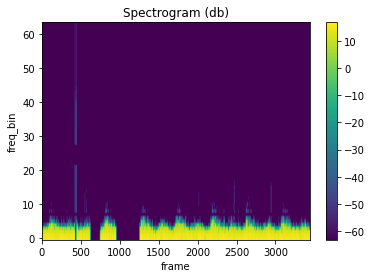

In [ ]:
plot_spectrogram(batch[0][0][0]);

Already Augmented

# The Model

## Training from Scratch

In [ ]:
class AudioClassifier (nn.Module):

    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [ ]:
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Validation Accuracy: {acc:.2f}')
  print(' ')

def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

    # Run inference on trained model with the validation set
    inference(myModel, val_dl)

In [ ]:
myModel = AudioClassifier()
myModel = myModel.to(device)
num_epochs=20
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 2.25, Accuracy: 0.17
Validation Accuracy: 0.38
Epoch: 1, Loss: 2.12, Accuracy: 0.50
Validation Accuracy: 0.51
Epoch: 2, Loss: 1.99, Accuracy: 0.64
Validation Accuracy: 0.64
Epoch: 3, Loss: 1.89, Accuracy: 0.68
Validation Accuracy: 0.72
Epoch: 4, Loss: 1.76, Accuracy: 0.73
Validation Accuracy: 0.77
Epoch: 5, Loss: 1.56, Accuracy: 0.76
Validation Accuracy: 0.78
Epoch: 6, Loss: 1.34, Accuracy: 0.77
Validation Accuracy: 0.77
Epoch: 7, Loss: 1.04, Accuracy: 0.82
Validation Accuracy: 0.84
Epoch: 8, Loss: 0.81, Accuracy: 0.85
Validation Accuracy: 0.89
Epoch: 9, Loss: 0.65, Accuracy: 0.87
Validation Accuracy: 0.89
Epoch: 10, Loss: 0.55, Accuracy: 0.86
Validation Accuracy: 0.89
Epoch: 11, Loss: 0.51, Accuracy: 0.86
Validation Accuracy: 0.90
Epoch: 12, Loss: 0.46, Accuracy: 0.87
Validation Accuracy: 0.88
Epoch: 13, Loss: 0.43, Accuracy: 0.88
Validation Accuracy: 0.89
Epoch: 14, Loss: 0.43, Accuracy: 0.88
Validation Accuracy: 0.92
Epoch: 15, Loss: 0.41, Accuracy: 0.88
Validation A

This notebook is getting messy so I will stop here and start a new final one for the blog post

***TO DO***

* in the blog version, fix the imbalance problem
* no random splitting, train test split from sklearn
* play around with the model
* see what I can improve in the training loop


***TO DO IN FUTURE***
* finish the fastai course part 2, redo part 1 with PyTorch only
* develop better training loops for PyTorch
* better tips and tricks for PyTorch from fastai
* blog about training with state of the art methods in PyTorch from fastai